In [1]:
1+3

4

MF does optimal signal/noise detection (https://www.eit.lth.se/fileadmin/eit/courses/phd009/DetTheory_chapter4.pdf), it doesn't produce sharp pulses for optimal pulse separation. 

MF is what  you'd run to do a cut on noisy pulses. Ideally it's what the digitizer would run. But in XENONnT, electronic noise has never been an issue, due to (a) the the filterbox installation (b) increasing the ADC thresholds in each channel to be well below the noise amplitude (c) various noisy pulse/hit rejection techniques in pax.



In [5]:
%run ~/common_init.py
import straxen
import strax

st = straxen.contexts.strax_workshop_dali()

Not saving raw_records while selecting a time range in the run


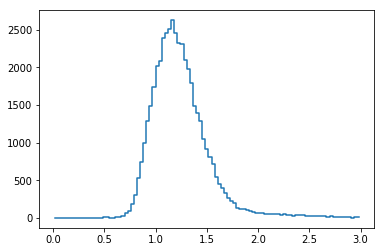

In [7]:
rr = st.get_array('180215_1029', 'raw_records', seconds_range=(0, 20))
ch = 45
rr = rr[(rr['channel'] == ch) &
        (rr['record_i'] == 0) &
        (rr['pulse_length'] < 110)]

ws0_all = rr['data'].astype(np.float) + (rr['baseline'] % 1)[:,np.newaxis]
area = ws0_all[:,45:70].sum(axis=1) * straxen.to_pe[ch]

area_hist = Hist1d(area, bins=np.linspace(0, 3, 100))
area_hist.plot()
mask = (area < 1.5) & (area > 0.5)
r = rr[mask]
ws0 = ws0_all[mask]

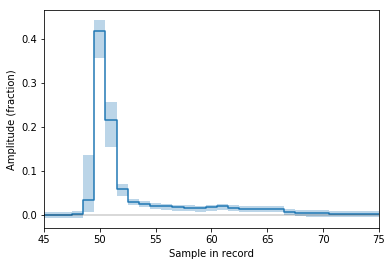

In [8]:
def roll_rows(A, r):
    return np.array([np.roll(row, x) for row,x in zip(A, r)])

def sample_xaxis():
    plt.xlabel("Sample in record")
    plt.xlim(45, 75)
    plt.axhline(0, c='k', alpha=0.2)

def get_pm(ws, plot=False, shorten=False, **kwargs):
    w = ws/ws.sum(axis=1)[:, np.newaxis]
    w = roll_rows(w, 50 - np.argmax(w, axis=1))
    pm = np.median(w, axis=0)
    pm /= pm.sum()
    
    if plot:
        x = np.arange(len(w[0]))
        plt.plot(x, pm, linestyle='steps-mid', **kwargs)
        plt.fill_between(
            x,
            np.percentile(w, 25, axis=0),
            np.percentile(w, 75, axis=0),
            step='mid', alpha=0.3, linewidth=0,
            **kwargs)
        plt.ylabel("Amplitude (fraction)")
        sample_xaxis()
    if shorten:
        pm = get_shortened(pm)
    return pm

def get_shortened(pm):
    pmc = np.argmax(pm)
    # Zero part far before pulse
    pm[:pmc-5] = 0
    # Retun symmetric, but not too long, result
    return pm[pmc-30:pmc+30]

pm0 = get_pm(ws0, plot=True)

In [9]:
from scipy.ndimage import convolve1d

def overlap_indices(a1, a2, b1, b2):
    # a: p, b: r
    s = a1 - b1
    n_b = b2 - b1
    n_a = a2 - a1
    
    if s <= -n_a:
        # B is completely right of a
        return (0,0), (0,0)

    # Range in b that overlaps with a
    b_start = max(0, s)
    b_end = min(n_b, s + n_a)
    assert b_end > b_start
            
    # Range of a that overlaps with b
    a_start = max(0, -s)
    a_end = min(n_a, -s + n_b)
    
    return (a_start, a_end), (b_start, b_end)

overlap_indices(3, 10, 5, 8)

def sharpen(w, pm):
    pmc = np.argmax(pm)
    w = w.astype(np.float)
    for i, x in enumerate(w):
        (w_start, w_end), (pm_start, pm_end) = overlap_indices(
            0, len(w), i - pmc, i - pmc + len(pm))
        bla = (x/pm[pmc] * pm[pm_start:pm_end])
        w[w_start:w_end] -= bla
        w[i] = x/pm[pmc]
    return w

def impulse(n):
    ir = np.zeros(2 * n, dtype=np.float)
    ir[n] = 1
    return ir
    
def impulse_response(pm):
    n = len(pm)
    ir = impulse(n)
    ir = sharpen(ir, pm)
    return ir

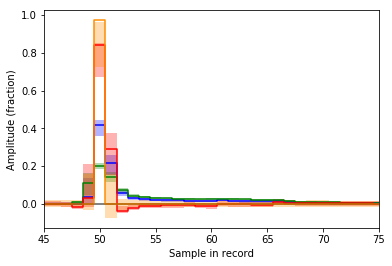

In [10]:
pm0 = get_pm(ws0, plot=True, color='b')

# Matched filter first to get rid of some noise
ws = convolve1d(ws0, pm0)
pm_m = get_pm(ws, plot=True, color='g')

# First sharpening
ir_sharp_1 = impulse_response(pm_m)
ws = convolve1d(ws, ir_sharp_1)
pm_sharp_1 = get_pm(ws, plot=True, color='r')

# Second sharpening
ir_sharp_2 = impulse_response(pm_sharp_1)
ws = convolve1d(ws, ir_sharp_2)
pm_sharp_2 = get_pm(ws, plot=False)

# Third sharpening
ir_sharp_3 = impulse_response(pm_sharp_2)
ws = convolve1d(ws, ir_sharp_3)
pm_sharp_3 = get_pm(ws, plot=True, color='darkorange')


# Could do third sharpening... too lazy for now

# Find combined filter
ir = impulse(20)
for r in [pm0, ir_sharp_1, ir_sharp_2, ir_sharp_3]:
    ir = np.convolve(ir, r, mode='full')
ir_combined = get_shortened(ir)
ir_combined /= ir_combined.sum()

# plt.plot(pm0, color='b', linestyle='steps-mid')
# plt.plot(ir0, linestyle='--', color='b', drawstyle='steps-mid', linewidth=1)
# plt.show()

(-0.1, 0.1)

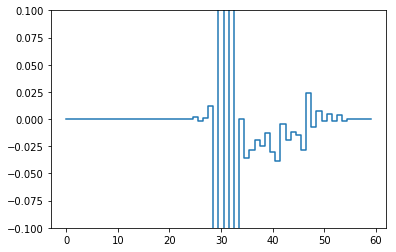

In [12]:
ir_combined[55:] = 0
ir_combined /= ir_combined.sum()
plt.plot(ir_combined, linestyle='steps-mid')
plt.ylim(-0.1, 0.1)

(-0.1, 0.1)

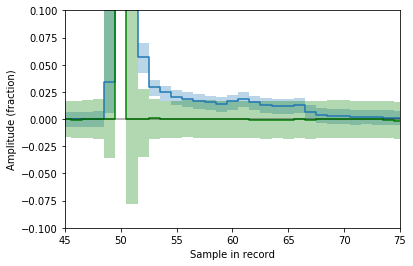

In [13]:
get_pm(ws0, plot=True)

ws = convolve1d(ws0, ir_combined, mode='constant')
pm_post = get_pm(ws, plot=True, color='g')
plt.ylim(-0.1, 0.1)
#plt.xlim(0, 100)

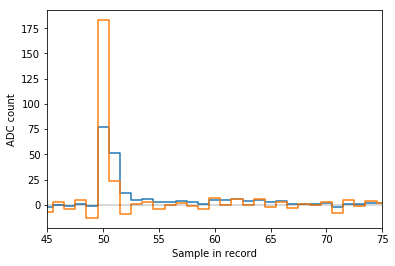

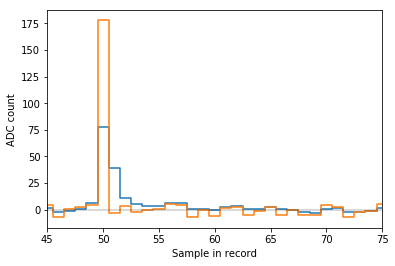

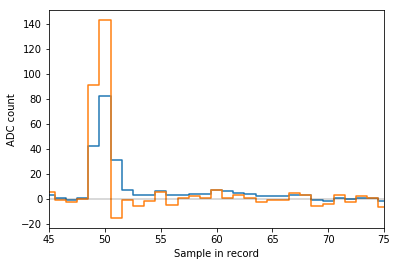

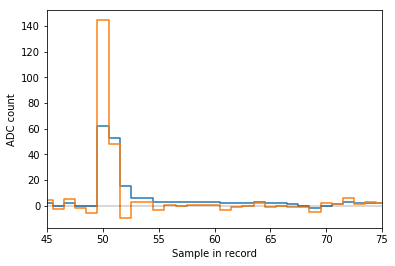

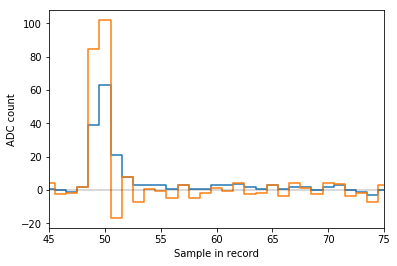

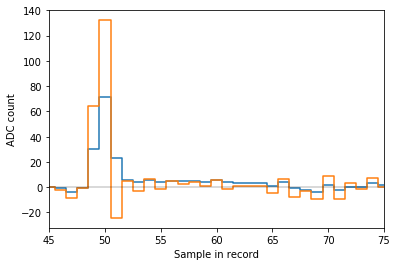

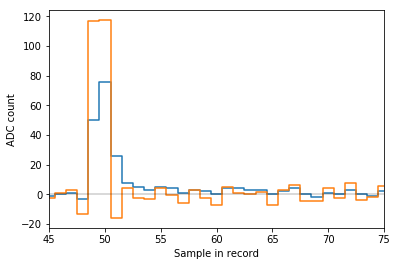

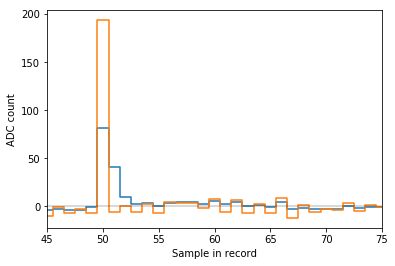

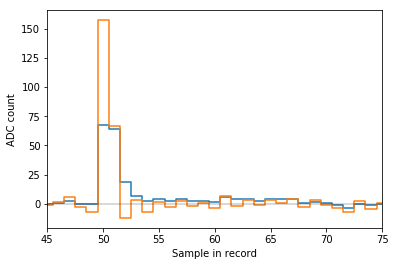

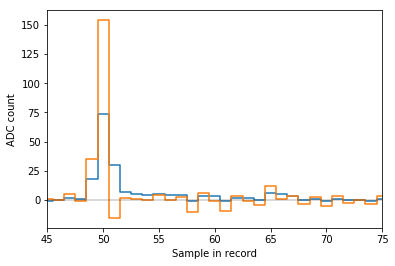

In [15]:
for i in range(10):
    for d in ws0, ws:
        plt.plot(d[i], linestyle='steps-mid')
    sample_xaxis()
    plt.ylabel("ADC count")
    plt.show()

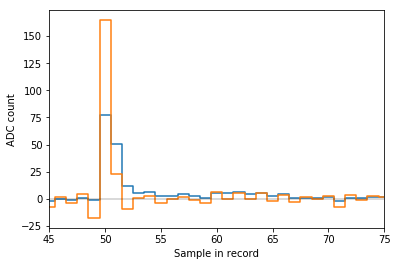

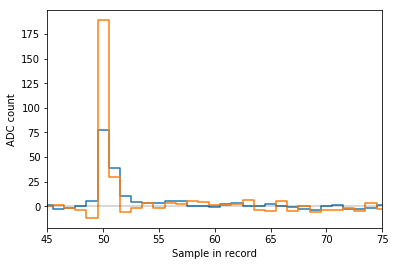

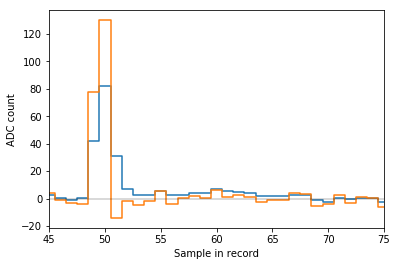

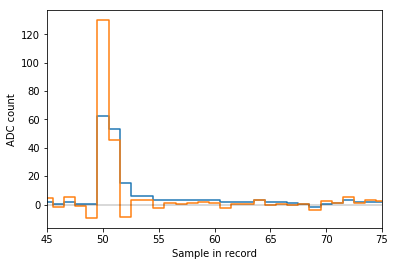

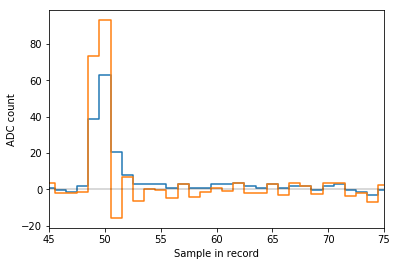

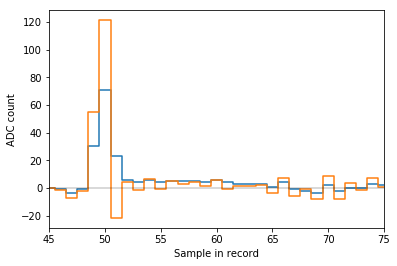

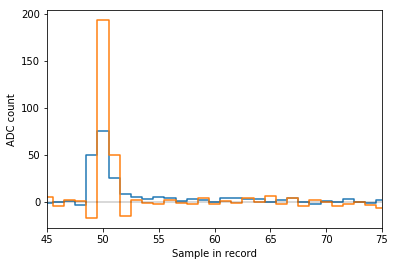

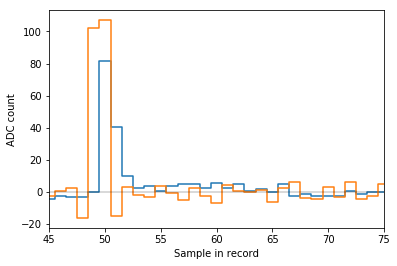

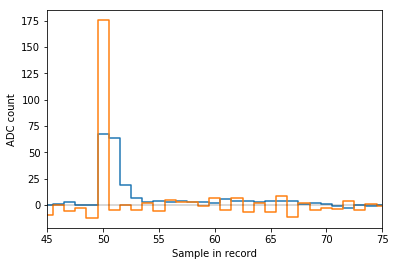

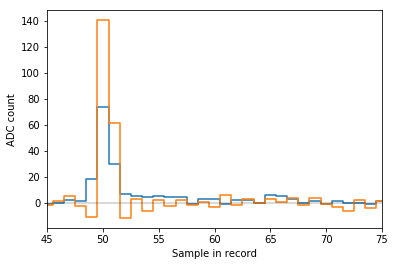

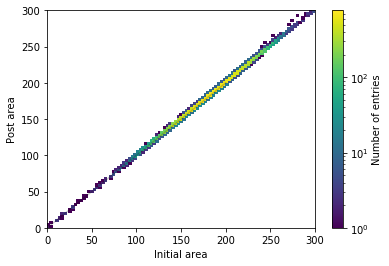

In [16]:
mh = Histdd(
        ws0.sum(axis=1), ws.sum(axis=1), 
        bins=(np.linspace(0, 300, 100), 
              np.linspace(0, 300, 100)))
mh.plot(log_scale=True)
plt.xlabel("Initial area")
plt.ylabel("Post area")
plt.plot([0, 200], [0, 200], color='k', alpha=0.2)

/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:479: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hist = self.histogram / sum_along_axis[self._simsalabim_slice(axis)]
/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:521: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = self.all_axis_bin_centers(axis=axis)[index]


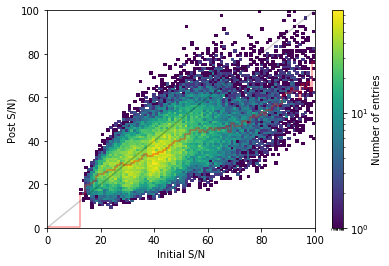

In [17]:
def sn(ws, bounds=(46, 70), noise_samples=40):
    sig = np.max(ws, axis=1)
    noise = (
        np.percentile(ws[:,:noise_samples], 100 * stats.norm.cdf(+1), axis=1) - 
        np.percentile(ws[:,:noise_samples], 100 * stats.norm.cdf(-1), axis=1))/2
    return sig/noise

mh = Histdd(
        sn(ws0), sn(ws), 
        bins=(np.linspace(0, 100, 100), np.linspace(0, 100, 100)))
mh.plot(log_scale=True)
mh.percentile(50, axis=1).plot(color='r', alpha=0.4)
plt.xlabel("Initial S/N")
plt.ylabel("Post S/N)")
plt.plot([0, 150], [0, 150], color='k', alpha=0.2)

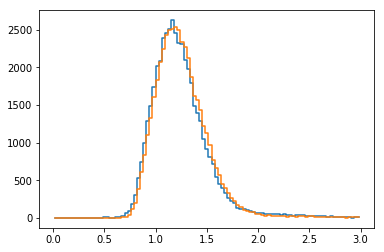

In [18]:
ws_all = convolve1d(ws0_all, ir_combined, mode='constant')
area_new = ws_all[:,47:54].sum(axis=1) * straxen.to_pe[ch]
area_hist.plot()
Hist1d(area_new, area_hist.bin_edges).plot()

# Record linking

In [259]:
q = np.random.randn(2, 100)
#q[0,99] = 20

q_true = convolve1d(np.concatenate(q).reshape(1, -1), ir_combined, mode='constant')[0]

In [280]:
prev_r

array([-1, -1, -1, ..., -1, -1, -1])

In [288]:
len(ir_combined)

60

In [286]:
#rr['record_i']

In [367]:
%%time
prev_r, next_r = strax.record_links(rr)


CPU times: user 1.75 ms, sys: 1.03 ms, total: 2.78 ms
Wall time: 1.59 ms


In [355]:
from scipy.ndimage import convolve1d

In [307]:
%%time
filter_records(ws0_all, ir_combined, prev_r, next_r)

CPU times: user 895 ms, sys: 22.8 ms, total: 918 ms
Wall time: 919 ms


array([[-0.25496817,  1.9957217 ,  5.93734348, ...,  1.23647592,
         1.01916337,  1.32941683],
       [ 1.79377884,  0.94128744, -1.34528796, ...,  1.00558523,
         0.86179408,  0.92126383],
       [ 3.45529037,  1.90000276, -4.8359183 , ...,  0.37335178,
         0.31813724,  0.37673774],
       ...,
       [ 3.8579303 , -0.39593114, -3.38255317, ...,  0.16735982,
         0.02713304,  0.18194046],
       [-0.1989896 , -2.96409915,  8.50237155, ...,  1.1582457 ,
         1.01741659,  1.14683961],
       [-2.79281868, -3.75660635, -0.50679912, ...,  0.88985248,
         1.00692566,  0.99757537]])

In [353]:
test_filter_records()

In [362]:
with np.printoptions(precision=3, suppress=True):
    print(np.array2string(ir_combined, separator=','))

[ 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
  0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
  0.   , 0.   , 0.   , 0.   , 0.   , 0.002,-0.002, 0.001, 0.012,-0.119,
  2.435,-1.271, 0.357,-0.174,-0.   ,-0.036,-0.028,-0.019,-0.025,-0.013,
 -0.03 ,-0.039,-0.005,-0.019,-0.012,-0.015,-0.029, 0.024,-0.007, 0.007,
 -0.001, 0.005,-0.002, 0.004,-0.002, 0.   , 0.   , 0.   , 0.   , 0.   ]


In [308]:


#     has_next = next_r != 
#     has_prev = prev_r != strax.processing.data_reduction.NOT_APPLICABLE

#     result[next_r[has_next],:a-1] += to_next[has_next]
#     result[prev_r[has_prev],-a:]  += to_prev[has_prev]
#     # q1[1,:a-1] += q_to_next[has_next]
#     # q1[0,-a:] += q_to_prev[1]
    
#     return result

# q_new = np.concatenate(q1)
# plt.plot(q_new - q_true, linestyle='steps-mid')
# plt.xlim(90, 120)

In [299]:
#convolve1d(ws0_all, ir_combined, mode='constant');

CPU times: user 303 ms, sys: 17.9 ms, total: 321 ms
Wall time: 320 ms


array([[-0.25496817,  1.9957217 ,  5.93734348, ...,  1.23647592,
         1.01916337,  1.32941683],
       [ 1.79377884,  0.94128744, -1.34528796, ...,  1.00558523,
         0.86179408,  0.92126383],
       [ 3.45529037,  1.90000276, -4.8359183 , ...,  0.37335178,
         0.31813724,  0.37673774],
       ...,
       [ 3.8579303 , -0.39593114, -3.38255317, ...,  0.16735982,
         0.02713304,  0.18194046],
       [-0.1989896 , -2.96409915,  8.50237155, ...,  1.1582457 ,
         1.01741659,  1.14683961],
       [-2.79281868, -3.75660635, -0.50679912, ...,  0.88985248,
         1.00692566,  0.99757537]])

In [297]:
%%time
ws_new = filter_records(ws0_all, ir, prev_r, next_r)

CPU times: user 8.19 s, sys: 41 ms, total: 8.24 s
Wall time: 8.25 s


In [292]:
len(ws0_all), len(rr)

(46863, 46863)

In [248]:
#np.abs((q_true - np.concatenate(q1))).sum()

(90, 120)

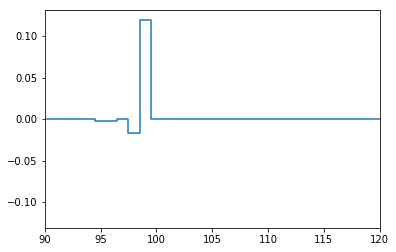

(90, 120)

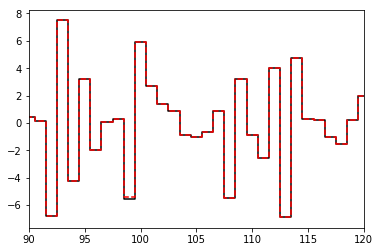

In [211]:
plt.plot(q_true, linestyle='steps-mid', c='k')
plt.plot(q_new, drawstyle='steps-mid', linestyle='--', c='r')
plt.xlim(90, 120)

### Try numba's np.convolve -- way too slow

In [81]:
import numba

@numba.njit
def convolve(ws, h):
    start = len(h)//2 - 1
    stop = start + len(ws[0])
    for i in range(len(ws)):
        
        result = np.convolve(ws[i], h)
        ws[i] = result[start:stop]
    #print(len(result), len(ws[i]), len(h))
   # break

In [79]:
%%time
convolve(ws0, ir_combined)

CPU times: user 3.15 s, sys: 1.06 ms, total: 3.15 s
Wall time: 3.15 s


In [80]:
%%time
convolve1d(ws0, ir_combined);

CPU times: user 260 ms, sys: 18 ms, total: 278 ms
Wall time: 277 ms


array([[   211.18139154,   -160.70645952,    150.87563107, ...,
          5231.23950268,  -1783.27274759,  -1365.97620352],
       [   398.33507921,   -356.7568208 ,    262.12740646, ...,
         20356.01782929, -20628.22668681,  16926.36544578],
       [  -164.88012146,    154.91911611,   -106.95410544, ...,
          2862.87818096,  -1440.86736187,    504.82861748],
       ...,
       [  -378.49965188,    293.59497899,   -223.95888053, ...,
         21353.0244583 , -27233.63819153,  26767.5393209 ],
       [   -39.60719778,     43.0693194 ,     49.92529615, ...,
         -2425.5391105 ,   1853.10695623,  -3064.45071179],
       [   223.61678246,   -144.68546903,     89.12950767, ...,
         -1169.47331494,  -5090.55284839,   9699.40643261]])

169


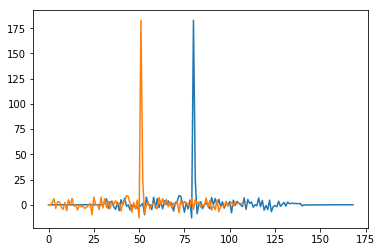

# OLD

In [70]:
#plt.plot(ir_combined, linestyle='steps-mid')

In [37]:
# get_pm(ws0, plot=True)
#

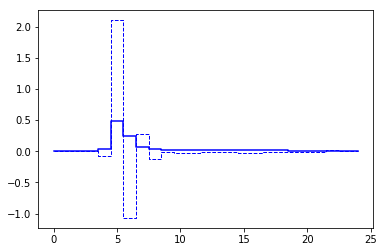

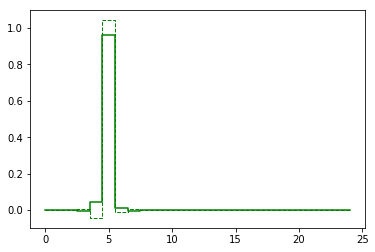

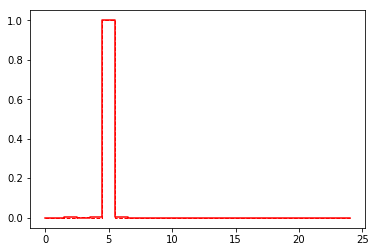

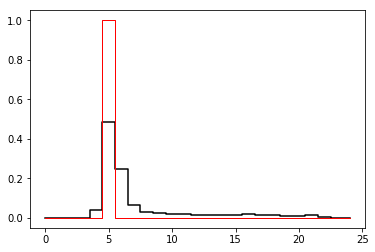

In [22]:



pm1 = center_pm(np.convolve(ir0, pm0, mode='full'))
ir1 = impulse_response(pm1)

plt.plot(pm1, color='g', linestyle='steps-mid')
plt.plot(ir1, linestyle='--', color='g', drawstyle='steps-mid', linewidth=1)
plt.show()

pm2 = center_pm(np.convolve(ir1, pm1, mode='full'))
ir2 = impulse_response(pm2)

plt.plot(pm2, color='r', linestyle='steps-mid')
plt.plot(ir2, linestyle='--', color='r', drawstyle='steps-mid', linewidth=1)
plt.show()


ir = impulse(20)
for r in [ir0, ir1, ir2]:
    ir = np.convolve(ir, r, mode='full')
    maxi = np.argmax(ir)
    
# Take symmetric filter to keep shape constant
s = 20
ir = np.concatenate([np.zeros(s), ir, np.zeros(s)])
ir = ir[maxi:maxi+2*s]

assert np.argmax(ir) == s == len(ir) // 2
    
pm_post = center_pm(np.convolve(pm0, ir, mode='full'))
plt.plot(pm0, color='k', linestyle='steps-mid')
# plt.plot(ir, linestyle='--', color='k', drawstyle='steps-mid', linewidth=1)
plt.plot(pm_post, color='r', drawstyle='steps-mid', linewidth=1)
plt.show()

This filter sharpens the PMT pulses considerably. The long tail is almost entirely gone:

(-0.1, 0.1)

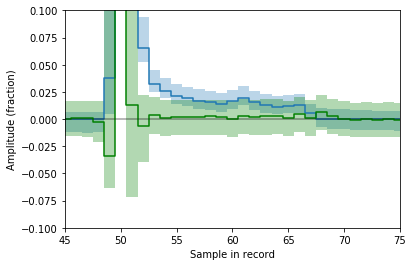

In [23]:

get_pm(ws0, plot=True)

ws_post = convolve1d(ws0, ir, mode='constant')
bias = np.median(ws_post[:,:30])
ws_post -= bias
pm_post = get_pm(ws_post, plot=True, color='g')

plt.ylim(-0.1, 0.1)

The effect on the per-sample S/N is mixed. For low S/N pulses it seems to increase it: perhaps these had two very similar-height bins originally, and this filter helps make one bin dominant?

/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:479: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hist = self.histogram / sum_along_axis[self._simsalabim_slice(axis)]
/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:521: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = self.all_axis_bin_centers(axis=axis)[index]


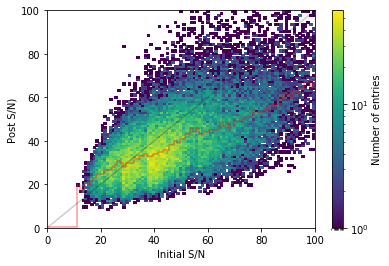

In [25]:
def sn(ws, bounds=(46, 70), noise_samples=20):
    sig = np.max(ws, axis=1)
    noise = (
        np.percentile(ws[:,:noise_samples], 100 * stats.norm.cdf(+1), axis=1) - 
        np.percentile(ws[:,:noise_samples], 100 * stats.norm.cdf(-1), axis=1))/2
    return sig/noise

mh = Histdd(
        sn(ws0), sn(ws_post), 
        bins=(np.linspace(0, 100, 100), np.linspace(0, 100, 100)))
mh.plot(log_scale=True)
mh.percentile(50, axis=1).plot(color='r', alpha=0.4)
plt.xlabel("Initial S/N")
plt.ylabel("Post S/N)")
plt.plot([0, 150], [0, 150], color='k', alpha=0.2)

Text(0, 0.5, 'ADC count')

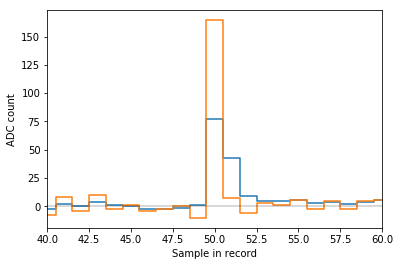

In [26]:
i = 32
for d in ws0, ws_post:
    plt.plot(d[i], linestyle='steps-mid')
sample_xaxis()
plt.xlim(40, 60)
plt.ylabel("ADC count")

In [27]:
# plt.plot(pm0)
# plt.plot(pm_post)

Note that we have not quite eliminated the bias in the immediately surrounding bins. This is because we put the three steps together in one filter, rather than re-aligning the pulses after the separate steps.

Note also that the amplitude in the central bin is often larger than one: the immediately surrounding bins will be < 0.

### Try matched filter first

/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:479: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  hist = self.histogram / sum_along_axis[self._simsalabim_slice(axis)]
/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/multihist.py:521: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = self.all_axis_bin_centers(axis=axis)[index]


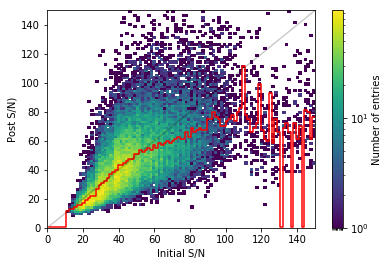

In [28]:
# Matched filter to increase s/n
ws_matched = convolve1d(ws0, pm0, mode='constant')

mh = Histdd(
        sn(ws0), sn(ws_matched), 
        bins=(np.linspace(0, 150, 100), np.linspace(0, 150, 100)))
mh.plot(log_scale=True)
mh.percentile(50, axis=1).plot(color='r')
plt.xlabel("Initial S/N")
plt.ylabel("Post S/N)")
plt.plot([0, 150], [0, 150], color='k', alpha=0.2)

In [30]:
q = np.where(sn(ws0) > 30)[0]

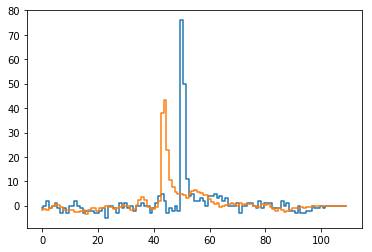

In [31]:
i = q[0]
plt.plot(ws0[i], linestyle='steps-mid')
plt.plot(ws_matched[i], linestyle='steps-mid')

# OLD

array([-3.87752544e-03, -3.21851304e-03, -3.50377848e-03, -5.17176544e-03,
       -5.33710779e-02,  1.35699976e+00,  1.43584537e-02, -1.34809566e-02,
        1.60711950e-03, -2.19197581e-03, -1.26951090e-03, -1.06825768e-03,
       -1.59699752e-03, -8.70745095e-04, -1.19984428e-03, -3.78364586e-03,
        7.42251869e-05, -1.35215552e-03, -6.26786230e-04,  1.03780295e-05,
       -2.80915660e-03,  2.91710426e-03, -2.14279876e-03,  5.60498821e-03,
       -6.11272865e-04])

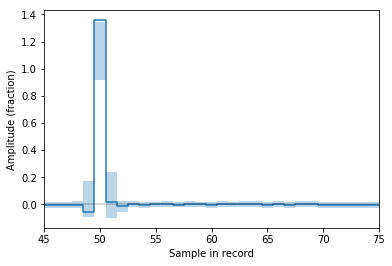

# Alt

In [340]:


@numba.njit
def sharpen(ws, pm, pmc):
    pmc = np.argmax(pm)
    for j in range(len(ws)):
        w = ws[j]
        for i, x in enumerate(w):
            # TODO: don't have to continuously compute these
            (w_start, w_end), (pm_start, pm_end) = overlap_indices(
                0, len(w), i - pmc, i - pmc + len(pm))
            bla = (x/pm[pmc] * pm[pm_start:pm_end])
            w[w_start:w_end] -= bla
            w[i] = x/pm[pmc]


(45, 60)

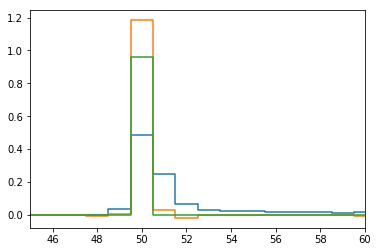

In [265]:
pm0, pmc0 = get_pm(ws0)

ws = ws0.copy()
sharpen(ws, pm, pmc)

ws1 = ws.copy()
pm1, pmc1 = get_pm(ws)
sharpen(ws, pm1, pmc1)

ws2 = ws.copy()
pm2, pmc2 = get_pm(ws)

for d in [pm, pm1, pm2]:
    plt.plot(d, linestyle='steps-mid')
plt.xlim(45, 60)

In [266]:
#ir[25:] = 0

In [267]:
# plt.plot(ir, linestyle='steps-mid')
# plt.axhline(0, alpha=0.3, c='k')
# plt.xlim(n - 5, n + 30)
# #plt.ylim(-0.1, 0.1)

In [285]:
def index_matrix(n):
    x0 = np.eye(2 * n).astype(np.int)
    x = 0 * x0
    for i in range(2 * n):
        x2 = np.roll(x0, i, axis=1)
        x2[:,:i] = 0
        x += i * x2
    return (n + (x.T - x))[:n,:n]

def impulse_response(pm, pmc):
    n = len(pm)
    ir = np.zeros(2 * n, dtype=np.float)
    ir[n] = 1
    sharpen(ir[np.newaxis,:], pm, pmc)
    ir[n + 30:] = 0
    ir[:n - 5] = 0
    return ir
    
def matrix_form(pm, pmc):
    return impulse_response(pm, pmc)[index_matrix(len(pm))]

Text(0, 0.5, 'Amplitude (fraction of total)')

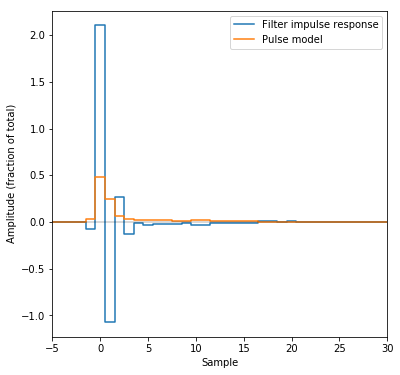

In [339]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2 * n) - n, 
         impulse_response(pm, pmc), 
         linestyle='steps-mid',
         label='Filter impulse response')
plt.xlim(-5, 30)
plt.plot(np.arange(n) - pmc, pm,
         linestyle='steps-mid',
         label='Pulse model')
plt.axvline(n, c='k', alpha=0.2)
plt.axhline(0, c='k', alpha=0.2)
plt.legend(loc='upper right')
plt.xlabel("Sample")
plt.ylabel("Amplitude (fraction of total)")

In [291]:
#np.correlate(ws0, impulse_response)

In [286]:
mf = matrix_form(pm0, pmc0) @ matrix_form(pm1, pmc1)

In [287]:
%%time
ws_new = (mf[np.newaxis,:,:] @ ws0[:,:,np.newaxis]).reshape(len(ws0), n)

CPU times: user 326 ms, sys: 2.8 ms, total: 329 ms
Wall time: 110 ms


In [288]:
r.nbytes/1e6

9.773689

In [289]:
ws0.nbytes/1e6

34.26632

(40, 70)

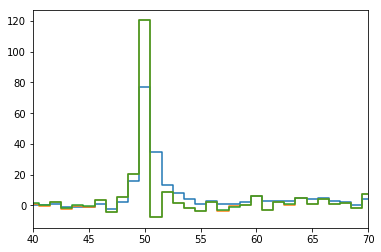

In [290]:
i = 456
for d in [ws0, ws_new, ws2]:
    plt.plot(d[i], linestyle='steps-mid')
plt.xlim(40, 70)

In [313]:
#ws0[0].max()

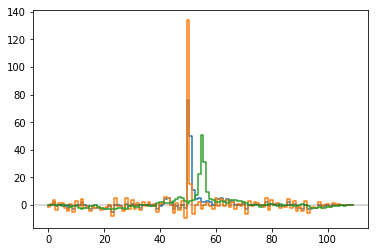

In [312]:
from scipy import signal
plt.plot(ws0[0], linestyle='steps-mid')
plt.plot(ws_new[0], linestyle='steps-mid')
#plt.plot(np.convolve(ws0[0], pm[::-1], mode='same'), linestyle='steps-mid')
plt.plot(signal.correlate(ws0[0], pm, mode='same'), linestyle='steps-mid')
plt.axhline(0, alpha=0.2, c='k')

# OLD

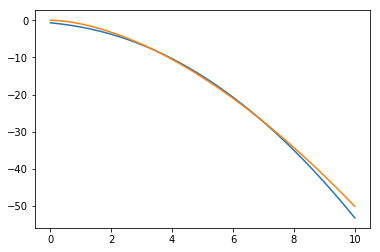

In [321]:
from scipy import stats
x = np.linspace(0, 10, 100)
plt.plot(x, stats.norm.logsf(x))
plt.plot(x, -x**1.7)

(45, 60)

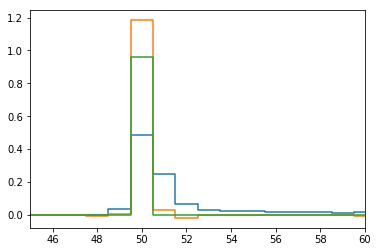

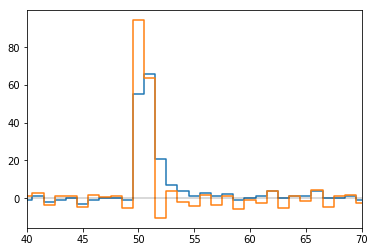

In [99]:
i = 99
for d in [ws0[i], ws[i]]:
    plt.plot(d, linestyle='steps-mid')

plt.xlim(40, 70)
plt.axhline(0, alpha=0.2, color='k')

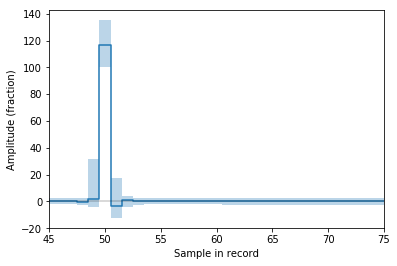

In [95]:
ns = np.arange(len(r['data'][0]))
plt.plot(ns, np.median(ws, axis=0), linestyle='steps-mid')
plt.fill_between(
    ns,
    np.percentile(ws, 25, axis=0),
    np.percentile(ws, 75, axis=0),
    step='mid', alpha=0.3, linewidth=0)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (fraction)")
plt.xlim(45, 75)
plt.axhline(0, c='k', alpha=0.2)

In [51]:
# plt.plot(pm, linestyle='steps-mid')
# plt.xlim(40, 60)

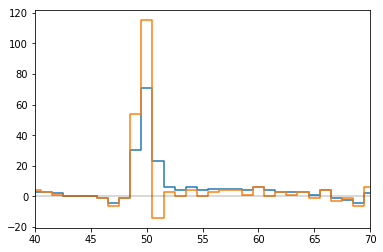

In [244]:
#w = np.random.randn(len(w)) * 10#rr[16]['data'].copy()
w = r[5]['data'].copy()
w_before = w.copy()

plt.plot(w, linestyle='steps-mid')

plt.plot(w, linestyle='steps-mid')
plt.xlim(40, 70)
plt.axhline(0, alpha=0.2, c='k')

In [ ]:
np.rr['data']

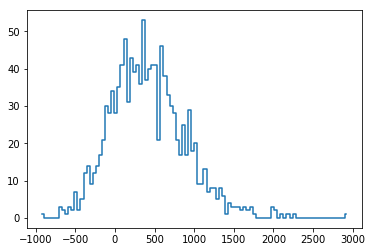

In [24]:
Hist1d(rr['area'], bins=100).plot()

In [3]:
st.select_runs()

Checking data availability: 100%|██████████| 5/5 [00:00<00:00, 364.72it/s]


,end,mode,name,number,start,tags,reader.ini.name,trigger.events_built,tags.name,event_info_available,raw_records_available,records_available,events_available,peaks_available
0,2017-06-21 07:17:25+00:00,background_stable,170621_0617,10635,2017-06-21 06:17:24+00:00,"blinded,_sciencerun1_candidate,_sciencerun1",NaN,NaN,NaN,False,True,False,False,False
1,2018-02-15 10:30:55+00:00,background_triggerless,180215_1029,16854,2018-02-15 10:29:52+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
2,2018-02-15 11:35:45+00:00,background_triggerless,180215_1035,16855,2018-02-15 10:35:42+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
3,2018-02-16 14:24:47+00:00,background_triggerless,180216_1324,16887,2018-02-16 13:24:43+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
4,2018-02-16 15:55:09+00:00,background_triggerless,180216_1455,16889,2018-02-16 14:55:06+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
5,2018-02-16 17:25:29+00:00,background_triggerless,180216_1625,16891,2018-02-16 16:25:26+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
6,2018-02-17 03:58:03+00:00,background_triggerless,180217_0257,16905,2018-02-17 02:58:00+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
7,2018-02-17 05:28:23+00:00,background_triggerless,180217_0428,16907,2018-02-17 04:28:20+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
8,2018-02-17 06:28:35+00:00,background_triggerless,180217_0528,16908,2018-02-17 05:28:32+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",NaN,NaN,NaN,False,True,False,False,False
9,2018-02-19 09:47:36+00:00,noise_monitoring_1ms_stable,180219_0946,16978,2018-02-19 09:46:35+00:00,noise,NaN,NaN,NaN,False,True,False,False,False
